# DQN
Trying to get DQN to work for MountainCar. Recall that Q learning is an off-policy learning scheme, meaning the TD update (and hence the TD error) is computing by maximizing over the action space. That is, we find:

$$ TD = Q(S, A) - (R + \gamma \max_A Q(S', A)) $$

Where an on-policy would simply have $Q(S', A')$ in place of $\max_A Q(S', A)$. The two main implementation details that seem to be necessary to get DQNs working are:
- Replay buffer: Collect samples in a buffer that gets sampled uniformly at random for training batches. This reduces sample correlation and, therefore, increases training convergence
- Separate policy and training networks: The policy network is used to generate samples, which are then used to train the training network. The policy network is updated to the training network after several training steps, which stabilizes the training process

In [59]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
env = gym.make("CartPole-v0")

In [141]:
class DQN(nn.Module):
    def __init__(self, S, A):
        super(DQN, self).__init__()
        
        self.S = S
        self.A = A
        H = 64
        
        self.d1 = nn.Linear(S, H)
        self.d2 = nn.Linear(H, H)
        self.d3 = nn.Linear(H, A)
        
    def forward(self, x):
        output = self.d1(x)
        output = F.relu(output)
        output = self.d2(output)
        output = F.relu(output)
        output = self.d3(output)
        return output

In [142]:
episodes = 50_000
epsilon = 1.0
gamma = .95
lr = 0.0001

batch_size = 100
max_memory = 10_000
    
S = env.observation_space.shape[0]
A = env.action_space.n

policy_net = DQN(S, A)

loss_criterion = nn.MSELoss()
optimizer = optim.Adam(policy_net.parameters(), lr=lr)

replay_buffer = []

losses = []
total_rewards = []
max_total_reward = -200

for episode in range(episodes):
    if episode % 2_000 == 0 and max_total_reward > 100:
        print("Successful run!")
        epsilon /= 2
    
    done = False
    
    state = env.reset()
    total_reward = 0
    
    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action_probs = policy_net(torch.tensor(state))
            action = torch.argmax(action_probs).detach().numpy()
            
        new_state, reward, done, _ = env.step(action)
        td_target = reward + gamma * torch.max(policy_net(torch.tensor(new_state)))
        total_reward += reward
        
        train_sample = (np.array(state), action, td_target.detach().numpy())
        replay_buffer.append(train_sample)
        
        if len(replay_buffer) > max_memory:
            replay_buffer.pop(0)
        
        state = new_state
        
        # ================== #
        batch = [random.choice(replay_buffer) for _ in range(batch_size)]
        batch_states, batch_actions, batch_targets = list(zip(*batch))

        batch_states  = torch.tensor(np.array(batch_states))
        batch_actions = torch.tensor(np.array(batch_actions))
        batch_targets = torch.tensor(np.array(batch_targets))

        predicted_qs = policy_net(batch_states)
        batch_indices = np.arange(batch_size, dtype=np.int64)
        predicted_targets = predicted_qs.gather(1, batch_actions.view(-1,1)).flatten() 
        
        loss = loss_criterion(predicted_targets, batch_targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().numpy())
    
#     print(total_reward)
        
#     if max_total_reward > -200:
#         print("Successful run!")
    
    max_total_reward = max(total_reward, max_total_reward)
    total_rewards.append(total_reward)

    if episode % 500 == 0:
        print(f"Epoch : {episode} / {episodes} -- Loss : {loss} -- Reward: {total_reward}")

Epoch : 0 / 50000 -- Loss : 1.095138430595398
Epoch : 500 / 50000 -- Loss : 0.4307306706905365
Epoch : 1000 / 50000 -- Loss : 0.28802597522735596
Epoch : 1500 / 50000 -- Loss : 0.36892035603523254
Epoch : 2000 / 50000 -- Loss : 0.3032427728176117
Epoch : 2500 / 50000 -- Loss : 0.3018014132976532
Epoch : 3000 / 50000 -- Loss : 0.31088873744010925
Epoch : 3500 / 50000 -- Loss : 0.25752267241477966
Successful run!
Epoch : 4000 / 50000 -- Loss : 0.28320202231407166
Epoch : 4500 / 50000 -- Loss : 0.6292383074760437
Epoch : 5000 / 50000 -- Loss : 0.47407397627830505
Epoch : 5500 / 50000 -- Loss : 0.7106286883354187
Successful run!
Epoch : 6000 / 50000 -- Loss : 0.5239637494087219
Epoch : 6500 / 50000 -- Loss : 0.5751075148582458


KeyboardInterrupt: 

In [ ]:
plt.plot(range(len(total_rewards)), total_rewards)
plt.show()

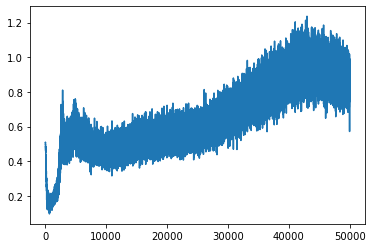

In [125]:
plt.plot(range(len(losses)), losses)
plt.show()

In [75]:
epsilon

5.960464477539063e-08

In [126]:
state = env.reset()
done = False
while not done:
    env.render(mode='rgb_array')
    action_probs = policy_net(torch.tensor(state))
    action = torch.argmax(action_probs).detach().numpy()
    state, _, done, _ = env.step(action)

In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

EPISODES = 1000
LEARNING_RATE = 0.0001
MEM_SIZE = 10000
BATCH_SIZE = 64
GAMMA = 0.95
EXPLORATION_MAX = 1.0
EXPLORATION_DECAY = 0.999
EXPLORATION_MIN = 0.001

FC1_DIMS = 1024
FC2_DIMS = 512
DEVICE = torch.device("cpu")

best_reward = 0
average_reward = 0
episode_number = []
average_reward_number = []

class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = env.observation_space.shape
        self.action_space = action_space

        self.fc1 = nn.Linear(*self.input_shape, FC1_DIMS)
        self.fc2 = nn.Linear(FC1_DIMS, FC2_DIMS)
        self.fc3 = nn.Linear(FC2_DIMS, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.loss = nn.MSELoss()
        self.to(DEVICE)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

class ReplayBuffer:
    def __init__(self):
        self.mem_count = 0
        
        self.states = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.actions = np.zeros(MEM_SIZE, dtype=np.int64)
        self.rewards = np.zeros(MEM_SIZE, dtype=np.float32)
        self.states_ = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.dones = np.zeros(MEM_SIZE, dtype=np.bool)
    
    def add(self, state, action, reward, state_, done):
        mem_index = self.mem_count % MEM_SIZE
        
        self.states[mem_index]  = state
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_
        self.dones[mem_index] =  1 - done

        self.mem_count += 1
    
    def sample(self):
        MEM_MAX = min(self.mem_count, MEM_SIZE)
        batch_indices = np.random.choice(MEM_MAX, BATCH_SIZE, replace=True)
        
        states  = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones   = self.dones[batch_indices]

        return states, actions, rewards, states_, dones

class DQN_Solver:
    def __init__(self):
        self.memory = ReplayBuffer()
        self.exploration_rate = EXPLORATION_MAX
        self.network = Network()

    def choose_action(self, observation):
        if random.random() < self.exploration_rate:
            return env.action_space.sample()
        
        state = torch.tensor(observation).float().detach()
        state = state.to(DEVICE)
        state = state.unsqueeze(0)
        q_values = self.network(state)
        return torch.argmax(q_values).item()
    
    def learn(self):
        if self.memory.mem_count < BATCH_SIZE:
            return
        
        states, actions, rewards, states_, dones = self.memory.sample()
        states = torch.tensor(states , dtype=torch.float32).to(DEVICE)
        actions = torch.tensor(actions, dtype=torch.long).to(DEVICE)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
        states_ = torch.tensor(states_, dtype=torch.float32).to(DEVICE)
        dones = torch.tensor(dones, dtype=torch.bool).to(DEVICE)
        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)

        q_values = self.network(states)
        next_q_values = self.network(states_)
        
#         predicted_value_of_now = torch.index_select(q_values, 1, actions) 
#         print(predicted_value_of_now.shape)
        
        predicted_value_of_now = q_values[batch_indices, actions]
#         print(predicted_value_of_now.shape)
#         print("=================================")
        
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0]
        
        q_target = rewards + GAMMA * predicted_value_of_future * dones
        
        loss = self.network.loss(q_target, predicted_value_of_now)
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def returning_epsilon(self):
        return self.exploration_rate

agent = DQN_Solver()

for i in range(1, EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    score = 0

    while True:
        #env.render()
        action = agent.choose_action(state)
        state_, reward, done, info = env.step(action)
        state_ = np.reshape(state_, [1, observation_space])
        agent.memory.add(state, action, reward, state_, done)
        agent.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward:
                best_reward = score
            average_reward += score 
            print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
            break
            
        episode_number.append(i)
        average_reward_number.append(average_reward/i)

plt.plot(episode_number, average_reward_number)
plt.show()

/var/folders/4j/yb1phr856mgf1c7fysrq3_6c0000gs/T/ipykernel_36517/2878368158.py:62: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.dones = np.zeros(MEM_SIZE, dtype=np.bool)


Episode 1 Average Reward 45.0 Best Reward 45.0 Last Reward 45.0 Epsilon 1.0
Episode 2 Average Reward 29.0 Best Reward 45.0 Last Reward 13.0 Epsilon 1.0
Episode 3 Average Reward 23.333333333333332 Best Reward 45.0 Last Reward 12.0 Epsilon 0.993020965034979
Episode 4 Average Reward 21.25 Best Reward 45.0 Last Reward 15.0 Epsilon 0.9782294672887405
Episode 5 Average Reward 24.0 Best Reward 45.0 Last Reward 35.0 Epsilon 0.9445671308589195
Episode 6 Average Reward 22.666666666666668 Best Reward 45.0 Last Reward 16.0 Epsilon 0.9295668775782806
Episode 7 Average Reward 23.428571428571427 Best Reward 45.0 Last Reward 28.0 Epsilon 0.9038873549665959
Episode 8 Average Reward 22.875 Best Reward 45.0 Last Reward 19.0 Epsilon 0.8868671875860644
Episode 9 Average Reward 22.333333333333332 Best Reward 45.0 Last Reward 18.0 Epsilon 0.8710385479118223
Episode 10 Average Reward 21.2 Best Reward 45.0 Last Reward 11.0 Epsilon 0.8615048875706075
Episode 11 Average Reward 20.818181818181817 Best Reward 45.0

Episode 81 Average Reward 64.25925925925925 Best Reward 226.0 Last Reward 151.0 Epsilon 0.005830965314140695
Episode 82 Average Reward 65.48780487804878 Best Reward 226.0 Last Reward 165.0 Epsilon 0.004943630640136612
Episode 83 Average Reward 66.62650602409639 Best Reward 226.0 Last Reward 160.0 Epsilon 0.004212346918856964
Episode 84 Average Reward 67.17857142857143 Best Reward 226.0 Last Reward 113.0 Epsilon 0.00376204772769516
Episode 85 Average Reward 69.2 Best Reward 239.0 Last Reward 239.0 Epsilon 0.0029619381600508587
Episode 86 Average Reward 69.52325581395348 Best Reward 239.0 Last Reward 97.0 Epsilon 0.0026879943090827602
Episode 87 Average Reward 71.01149425287356 Best Reward 239.0 Last Reward 199.0 Epsilon 0.0022027261208967326
Episode 88 Average Reward 72.9090909090909 Best Reward 239.0 Last Reward 238.0 Epsilon 0.0017359879235368028
Episode 89 Average Reward 73.47191011235955 Best Reward 239.0 Last Reward 123.0 Epsilon 0.0015349765724807553
Episode 90 Average Reward 74.8

KeyboardInterrupt: 

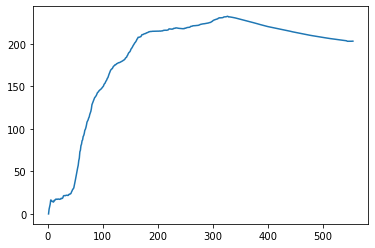

In [115]:
plt.plot(episode_number, average_reward_number)
plt.show()